In [2]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [3]:
# Helper function to download data and extract it if not already done
import os

def get_data_extract():
    if "food-101" in os.listdir("/content"):
        print("Dataset already exists in /content/food-101")
    else:
        print("Downloading the data...")
        !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -O /content/food-101.tar.gz
        print("Dataset downloaded!")
        print("Extracting data...")
        !tar -xzvf /content/food-101.tar.gz -C /content
        print("Extraction done!")

# Call the function to ensure dataset is available
get_data_extract()


Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [4]:
DATASET_PATH = '/content/food-101/images'


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = 299  # InceptionV3 default input size
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Normalize pixel values to [0, 1]
    rotation_range=20,            # Randomly rotate images by 20 degrees
    width_shift_range=0.2,        # Shift images horizontally
    height_shift_range=0.2,       # Shift images vertically
    shear_range=0.2,              # Shear intensity
    zoom_range=0.2,               # Zoom in and out
    horizontal_flip=True,         # Randomly flip images
    validation_split=0.2          # Set aside 20% for validation
)

# Preprocessing for validation (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

# Load training data
train_data = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'   # Use the training subset
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Use the validation subset
)


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


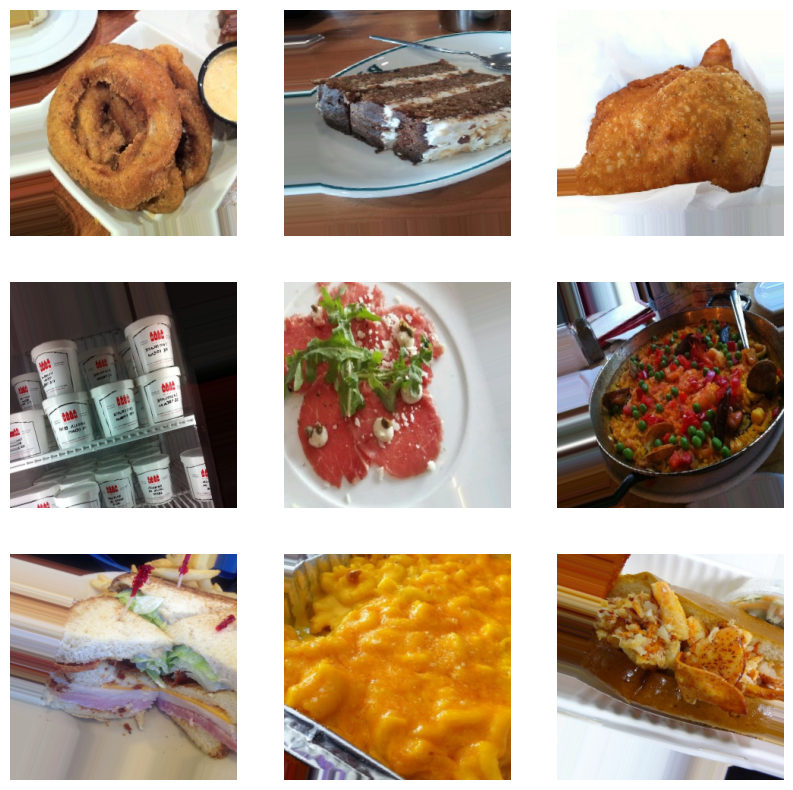

In [6]:
import matplotlib.pyplot as plt

# Display some augmented training images
sample_images, sample_labels = next(train_data)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.show()


In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model pre-trained on ImageNet, excluding top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers for our Food-101 classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(101, activation='softmax')(x)  # Output layer for 101 classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with corrected learning rate parameter
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
IMG_SIZE = 299  # Update IMG_SIZE to 299

# Update the data generator to use 299x299 images
train_data_small = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# The rest of the training code remains the same


Found 80800 images belonging to 101 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam

# Constants
IMG_SIZE = 299
NUM_CLASSES = 101

# Define input layer with specified shape
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Load InceptionV3 without the top layers, using the specified input layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)   # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer

# Define the model linking input to output
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model structure
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 149, 149, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 147, 147, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 147, 147, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 73, 73, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 73, 73, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 24,004,485 (91.57 MB)

 Trainable params: 2,201,701 (8.40 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
# Define target size for InceptionV3
IMG_SIZE = 299

# Updated ImageDataGenerator for training and validation with target_size=(299, 299)
train_data_small = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 299x299
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 299x299 for validation
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)



Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2696s 3s/step - accuracy: 0.0145 - loss: 39.2198 - val_accuracy: 0.0239 - val_loss: 23.2519
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2668s 3s/step - accuracy: 0.0242 - loss: 21.5545 - val_accuracy: 0.0253 - val_loss: 19.8152
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2647s 3s/step - accuracy: 0.0303 - loss: 17.8928 - val_accuracy: 0.0278 - val_loss: 17.7293
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2634s 3s/step - accuracy: 0.0363 - loss: 15.8327 - val_accuracy: 0.0279 - val_loss: 16.7723
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2626s 3s/step - accuracy: 0.0430 - loss: 14.2925 - val_accuracy: 0.0320 - val_loss: 15.2582
History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


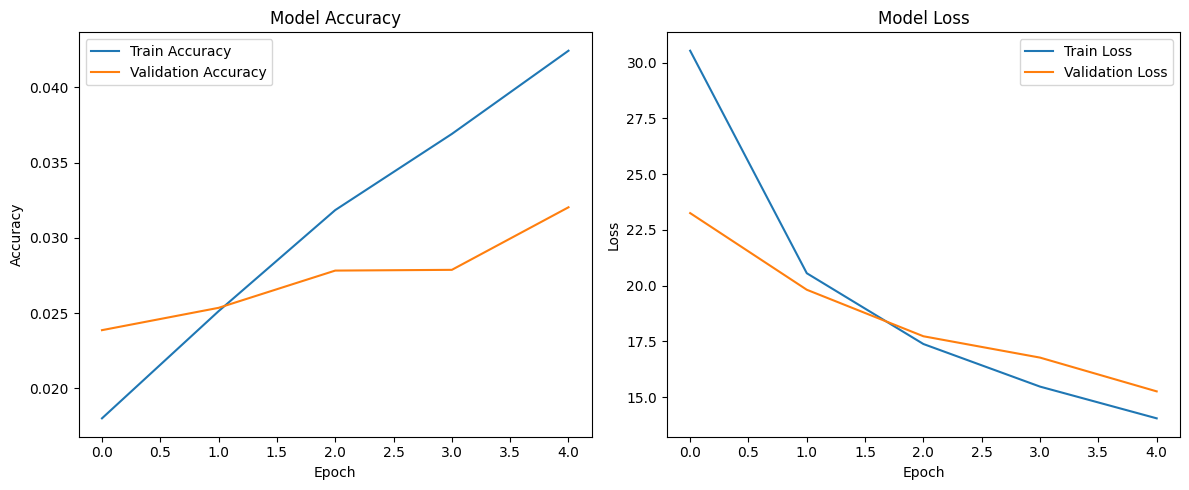

In [25]:
# Import necessary libraries
!pip install tensorflow --upgrade
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Parameters
EPOCHS = 5  # Increase epochs for better training
BATCH_SIZE = 32
IMG_SIZE = 150  # Reduced image size for faster processing
NUM_SAMPLES = 1000  # Limit number of samples for faster training

# Load and resize data
train_data_small = tf.keras.preprocessing.image_dataset_from_directory(
    'food-101/images',  # Adjust the path as needed
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
).take(NUM_SAMPLES)  # Take a limited number of samples

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'food-101/images',  # Adjust the path as needed
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Initialize InceptionV3 model
base_model = tf.keras.applications.InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax')  # 101 classes for Food-101
])

# Compile the model using Sparse Categorical Crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_food101_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_data_small,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Check the history object
print("History keys:", history.history.keys())

# Visualization of accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
